In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import pickle
import glob
import cv2
import os
from IPython.display import display, Image
from concurrent.futures import ThreadPoolExecutor

In [3]:
languages = {'en', 'fr', 'es'}
decades = {2000, 2010, 2020}
current_year = 2024
vote_thresh = 200
cols = ['id', 'original_language', 'poster_path', 'release_date', 'adult', 'vote_count']

df = pd.read_csv('input/TMDB.csv', usecols=cols).dropna()
initial_df_len = len(df)
print(f'Dataset contains {initial_df_len} records')

Dataset contains 709661 records


In [4]:
df = df[~df['adult']]

df['release_year'] = pd.to_datetime(df['release_date']).dt.year
df['release_decade'] = (df['release_year'] // 10) * 10
df = df.query('release_decade in @decades and release_year <= @current_year')

df = df.query('vote_count > @vote_thresh')

df = df.query('original_language in @languages')

df = df[['id', 'original_language', 'poster_path', 'release_decade']]

print(f'Filtered {initial_df_len - len(df)} records')

Filtered 702484 records


In [9]:
def pickle_df():
    global df
    
    data = []

    path = 'output/posters/{lang}/{id}.jpg'
    url = 'http://image.tmdb.org/t/p/w500{poster_path}'
    
    for lang in languages:
        os.makedirs(f'output/posters/{lang}', exist_ok=True)
        
        data.extend([(path.format(lang=lang, id=row.id), url.format(poster_path=row.poster_path)) for row in df[df['original_language'] == lang].itertuples()])

    with open('input/posters.pkl', 'wb') as f:
        pickle.dump(data, f)

pickle_df()

In [11]:
def load_posters():
    global df
    with ThreadPoolExecutor(max_workers=32) as executor:
        posters = list(executor.map(resize_poster, glob.iglob('output/posters/**/*.jpg')))
    return posters


def resize_poster(path, size=448):
    im = cv2.imread(path)
    
    old_size = im.shape[:2]
    
    ratio = float(size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    im = cv2.resize(im, (new_size[1], new_size[0]))
    
    delta_h, delta_w = size - new_size[0], size - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    return cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))


def compute_shannon_entropy(poster):    
    histogram, _ = np.histogram(poster.flatten(), bins=256, range=(0, 256), density=True)
    
    histogram = histogram[histogram > 0]
    
    entropy = -np.sum(histogram * np.log2(histogram))
    
    return entropy


def display_resized_poster(poster):
    im = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
    _, jpg = cv2.imencode('.jpg', im)
    display(Image(data=jpg.tobytes()))


def display_poster_grid(path_list):
    grid_size = int(np.ceil(np.sqrt(len(path_list))))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))

    for idx, image_path in enumerate(path_list):
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        row = idx // grid_size
        col = idx % grid_size
        
        axes[row, col].imshow(image_rgb)
        axes[row, col].axis('off')
    
    for i in range(len(path_list), grid_size * grid_size):
        fig.delaxes(axes.flatten()[i])
    
    plt.tight_layout()
    plt.show()

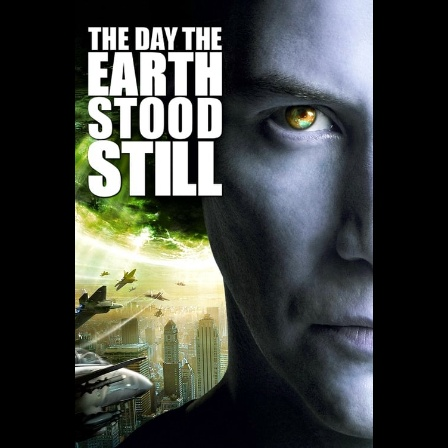

In [23]:
display_resized_poster(random.choice(load_posters()))

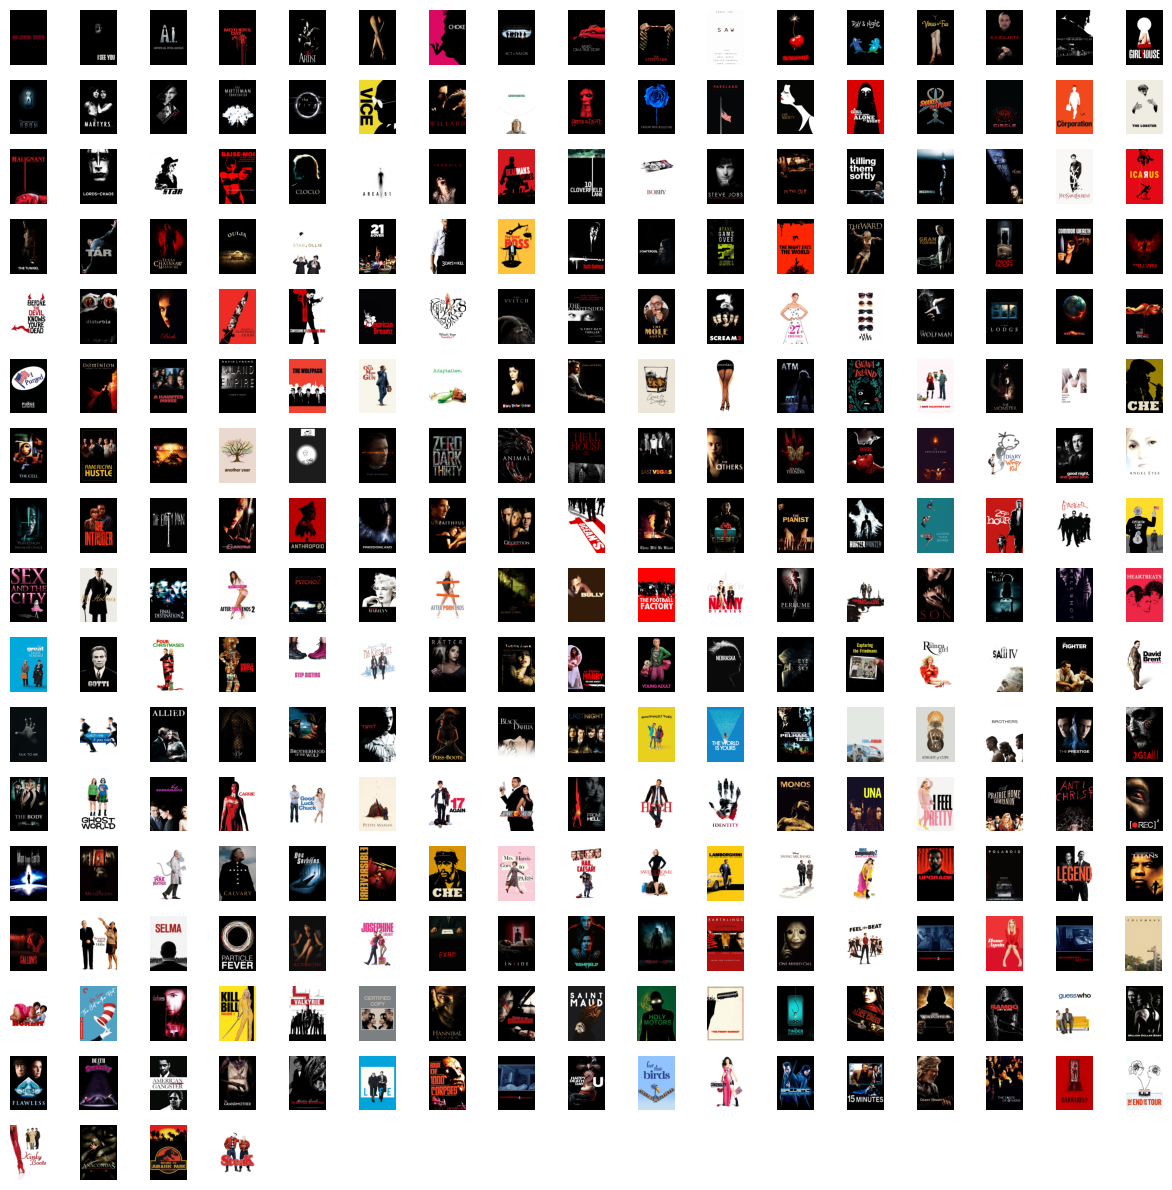

In [21]:
def filter_low_entropy_posters(posters, prune=False):
    bw_posters = np.array([cv2.cvtColor(poster, cv2.COLOR_BGR2GRAY) for poster in posters])
    entropies = [compute_shannon_entropy(poster) for poster in bw_posters]
    
    entropy_map = list(sorted(zip(glob.glob('output/posters/**/*.jpg'), entropies), key=lambda x: x[1]))
    low_entropy_posters = [ el[0] for el in entropy_map if el[1] <= 3.5 ]

    display_poster_grid(low_entropy_posters)

    if prune:
        for poster in low_entropy_posters:
            os.remove(poster)  

filter_low_entropy_posters(load_posters(), prune=True)